In [1]:
import pandas as pd
import numpy as np
import torch
import tqdm
import os
import glob
import cv2
import skimage.metrics as metrics
import matplotlib.pyplot as plt
import re
import model as autoencoder
from torchvision import transforms
import matplotlib.lines as mlines

In [2]:
test_images_path = '/home/maciejka/Desktop/school/S8/labwork-project/db/dataset_preprocessed/test'
path_to_models = '/home/maciejka/Desktop/school/S8/labwork-project/models'
path_to_history = '/home/maciejka/Desktop/school/S8/labwork-project/history'

models = sorted(glob.glob(os.path.join(path_to_models,'*.pth')))
histories = sorted(glob.glob(os.path.join(path_to_history,'*.csv')))

test_gt = sorted(glob.glob(os.path.join(test_images_path,'input', '*.bmp')))
test_input = sorted(glob.glob(os.path.join(test_images_path,'output', '*.bmp')))



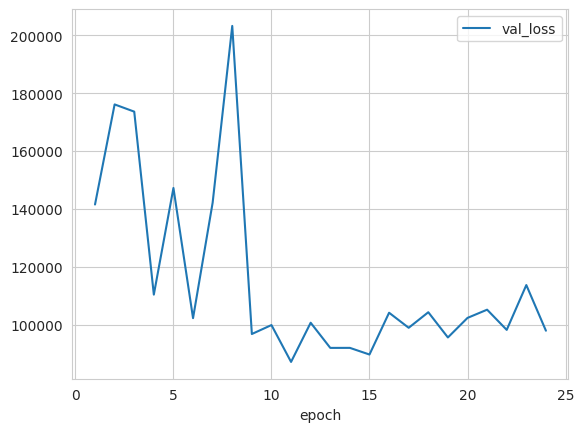

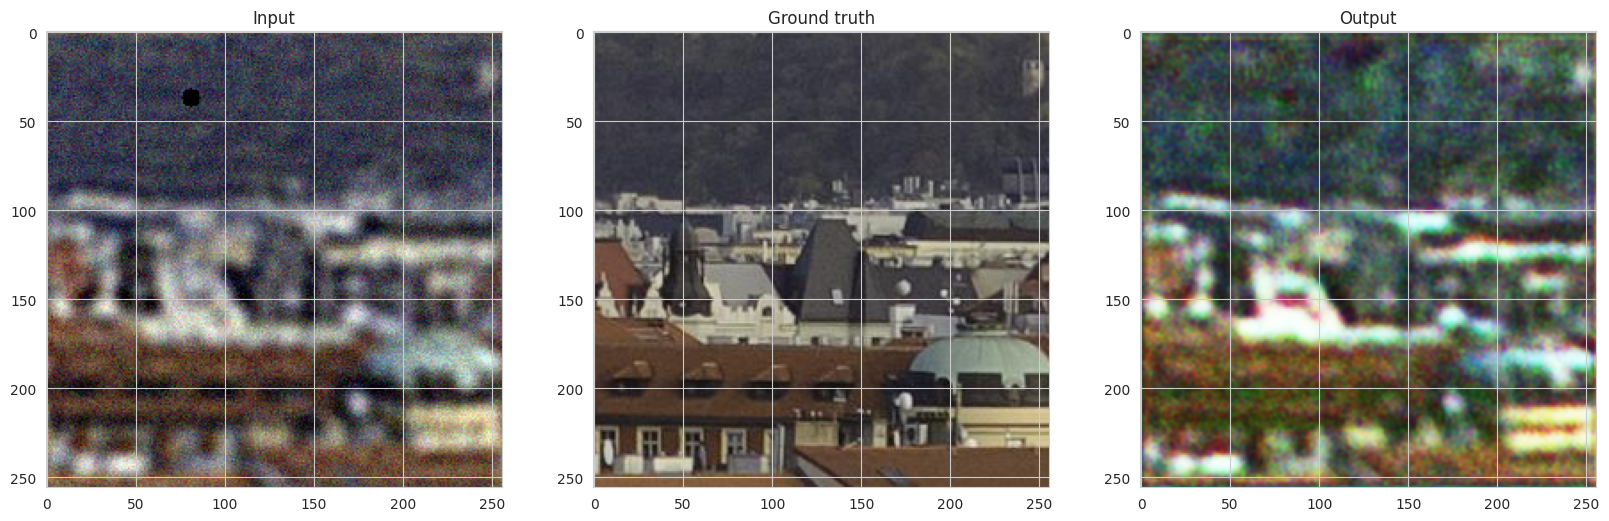

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
def get_model_infos(text, debug = False):

    loss_pattern = r'_(frequency|mse|focal)_loss'
    stacks_pattern = r'_(\d+)stacks'
    csize_pattern = r'_(\d+)Csize'
    zsize_pattern = r'_(\d+)Zsise'  # <-- change to 'Zsize' if typo

    loss = re.search(loss_pattern, text).group(1)
    stacks = re.search(stacks_pattern, text).group(1)
    csize = re.search(csize_pattern, text).group(1)
    zsize = re.search(zsize_pattern, text).group(1)

    if debug:
        print("Loss:", loss)
        print("Stacks:", stacks)
        print("Csize:", csize)
        print("Zsize:", zsize)

    return loss, stacks, csize, zsize

def get_test_data_infos(text, debug = False):

    loss_pattern = r'_(frequency|mse|focal)_loss'
    stacks_pattern = r'_(\d+)stacks'
    csize_pattern = r'_(\d+)csize'
    zsize_pattern = r'_(\d+)zsize'  # <-- change to 'Zsize' if typo

    loss = re.search(loss_pattern, text).group(1)
    stacks = re.search(stacks_pattern, text).group(1)
    csize = re.search(csize_pattern, text).group(1)
    zsize = re.search(zsize_pattern, text).group(1)

    if debug:
        print("Loss:", loss)
        print("Stacks:", stacks)
        print("Csize:", csize)
        print("Zsize:", zsize)

    return loss, stacks, csize, zsize

def load_model_and_history(loss, stacks, csize, zsize, only_history=False):
    model_regex = (os.path.join(path_to_models, f'model_*_{loss}_loss_{stacks}stacks_3colors_{csize}Csize_{zsize}Zsise.pth'))
    history_regex = (os.path.join(path_to_history, f'model_*_{loss}_loss_{stacks}stacks_3colors_{csize}Csize_{zsize}Zsise.csv'))

    model_path = glob.glob(model_regex)
    history_path = glob.glob(history_regex)
    history = pd.read_csv(*history_path)

    if not only_history:
        model = autoencoder.ChainedAutoencoder(int(stacks), 3 , int(csize), int(zsize), 'unet')
        model.load_state_dict(torch.load(*model_path, map_location=torch.device('cpu')))
        return model, history
    else:
        return history


def load_test_data(loss, stacks, csize, zsize):
    test_data_regex = (os.path.join('test_data', f'test_data_{loss}_loss_{stacks}stacks_{csize}csize_{zsize}zsize.csv'))
    test_data_path = glob.glob(test_data_regex)
    return pd.read_csv(*test_data_path)



def classify_image(model, image, gt_path, output='metrics'):
    image_numpy = cv2.imread(image, cv2.IMREAD_COLOR)
    image_numpy = cv2.cvtColor(image_numpy, cv2.COLOR_BGR2RGB)

    gt = cv2.imread(gt_path, cv2.IMREAD_COLOR)
    gt = cv2.cvtColor(gt, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0

    input_tensor = transform(image_numpy).unsqueeze(0)
    image_output = model(input_tensor)
    pred = image_output.detach().numpy()[0].transpose(1, 2, 0)

    mse = metrics.mean_squared_error(gt, pred)
    psnr = metrics.peak_signal_noise_ratio(gt, pred)

    ssim = metrics.structural_similarity(gt, pred, channel_axis=2, data_range=1)

    if output == 'metrics':
        return mse, psnr, ssim
    elif output == 'image':
        return pred
    else:
        raise ValueError("Invalid output type. Choose 'metrics' or 'image'.")


def test_image_context(model, im, gt):

    output = classify_image(model, im, gt, output='image')

    im_in = cv2.imread(im, cv2.IMREAD_COLOR)
    im_in = cv2.cvtColor(im_in, cv2.COLOR_BGR2RGB)

    gt = cv2.imread(gt, cv2.IMREAD_COLOR)
    gt = cv2.cvtColor(gt, cv2.COLOR_BGR2RGB)

    fig, ax = plt.subplots(1, 3, figsize=(20, 10))

    ax[0].imshow(im_in)
    ax[0].set_title('Input')
    ax[1].imshow(gt)
    ax[1].set_title('Ground truth')
    ax[2].imshow(output)
    ax[2].set_title('Output')

def calculate_metrics(model, test_input, test_gt):
    output_dict = {
        'img': [],
        'mse': [],
        'psnr': [],
        'ssim': [],
    }

    for in_path, gt_path in tqdm.tqdm(zip(test_input, test_gt), total=len(test_input), desc='Calculating metrics...', leave=False):
        mse, psnr, ssim = classify_image(model, in_path, gt_path, output='metrics')
        output_dict['img'].append(in_path)
        output_dict['mse'].append(mse)
        output_dict['psnr'].append(psnr)
        output_dict['ssim'].append(ssim)


    df = pd.DataFrame(output_dict)
    return df




infos = get_model_infos(models[0])
model, history = load_model_and_history('focal', 1, 64, 1024)
history.plot(x='epoch', y='val_loss')
test_image_context(model, test_input[15], test_gt[15])


In [4]:
i = 1
for model_path in models:
    print('model {} / {}'.format(i, len(models)))
    loss, stacks, csize, zsize = get_model_infos(model_path)
    path = '/home/maciejka/Desktop/school/S8/labwork-project/test_data/test_data_{}_loss_{}stacks_{}csize_{}zsize.csv'.format(loss, stacks, csize, zsize)
    print(path)
    model, history = load_model_and_history(loss, stacks, csize, zsize)
    met = calculate_metrics(model, test_input, test_gt)
    met.to_csv(path, index=False)
    i += 1

model 1 / 4
/home/maciejka/Desktop/school/S8/labwork-project/test_data/test_data_focal_loss_1stacks_64csize_1024zsize.csv


model 2 / 4
/home/maciejka/Desktop/school/S8/labwork-project/test_data/test_data_mse_loss_1stacks_64csize_1024zsize.csv


model 3 / 4
/home/maciejka/Desktop/school/S8/labwork-project/test_data/test_data_focal_loss_2stacks_64csize_1024zsize.csv


model 4 / 4
/home/maciejka/Desktop/school/S8/labwork-project/test_data/test_data_mse_loss_2stacks_64csize_1024zsize.csv


In [5]:
test_datas = glob.glob(os.path.join('test_data', 'test_data_*.csv'))
output_dict = {
    'loss': [],
    'stacks': [],
    'csize': [],
    'zsize': [],

    'training_time': [],
    'loss_training': [],
    'mse': [],
    'psnr': [],
    'ssim': [],

}
for test_data in test_datas:
    loss, stacks, csize, zsize = get_test_data_infos(test_data)
    df_history = load_model_and_history(loss, stacks, csize, zsize, only_history=True)

    df_test = pd.read_csv(test_data)
    print(df_history)

    output_dict['loss'].append(loss)
    output_dict['stacks'].append(stacks)
    output_dict['csize'].append(csize)
    output_dict['zsize'].append(zsize)
    output_dict['training_time'].append(df_history['time'].iloc[-1])
    output_dict['loss_training'].append(df_history['val_loss'].iloc[-1])

    #
    mse = df_test['mse'].mean()
    psnr = df_test['psnr'].mean()
    ssim = df_test['ssim'].mean()

    output_dict['mse'].append(mse)
    output_dict['psnr'].append(psnr)
    output_dict['ssim'].append(ssim)

output_df = pd.DataFrame(output_dict)

output_df


    epoch           loss       val_loss        time
0       1  473434.875808  141590.578125   34.585577
1       2  217250.653287  176105.159255   82.615593
2       3  203099.232355  173616.052885  114.794055
3       4  181194.792969  110521.064303  145.778474
4       5  171676.683459  147287.618990  210.191318
5       6  168947.410022  102402.553786  240.973222
6       7  177054.303071  142222.723858  286.075810
7       8  158341.056708  203174.278846  317.449995
8       9  146119.471444   96931.105469  349.903229
9      10  141874.425445  100019.060397  383.562952
10     11  143428.491716   87305.819712  416.251313
11     12  137250.214440  100819.637620  450.358039
12     13  125650.984644   92142.166166  481.956716
13     14  119622.819740   92150.389724  513.065617
14     15  112713.433998   89857.060246  544.775956
15     16  117298.763874  104270.081430  575.917088
16     17  111979.010574   99076.629808  606.813739
17     18  110960.623114  104439.440805  639.378587
18     19  1

loss stacks csize zsize  training_time  loss_training       mse  \
0  focal      1    64  1024     827.819490   98071.503606  0.035467   
1    mse      1    64  1024     844.026299       0.007007  0.029257   
2    mse      2    64  1024    1128.494073       0.007649  0.034455   
3  focal      2    64  1024    1045.450480   96400.137320  0.041265   

        psnr      ssim  
0  15.284285  0.391631  
1  16.427317  0.550164  
2  15.639504  0.525176  
3  14.448386  0.313604

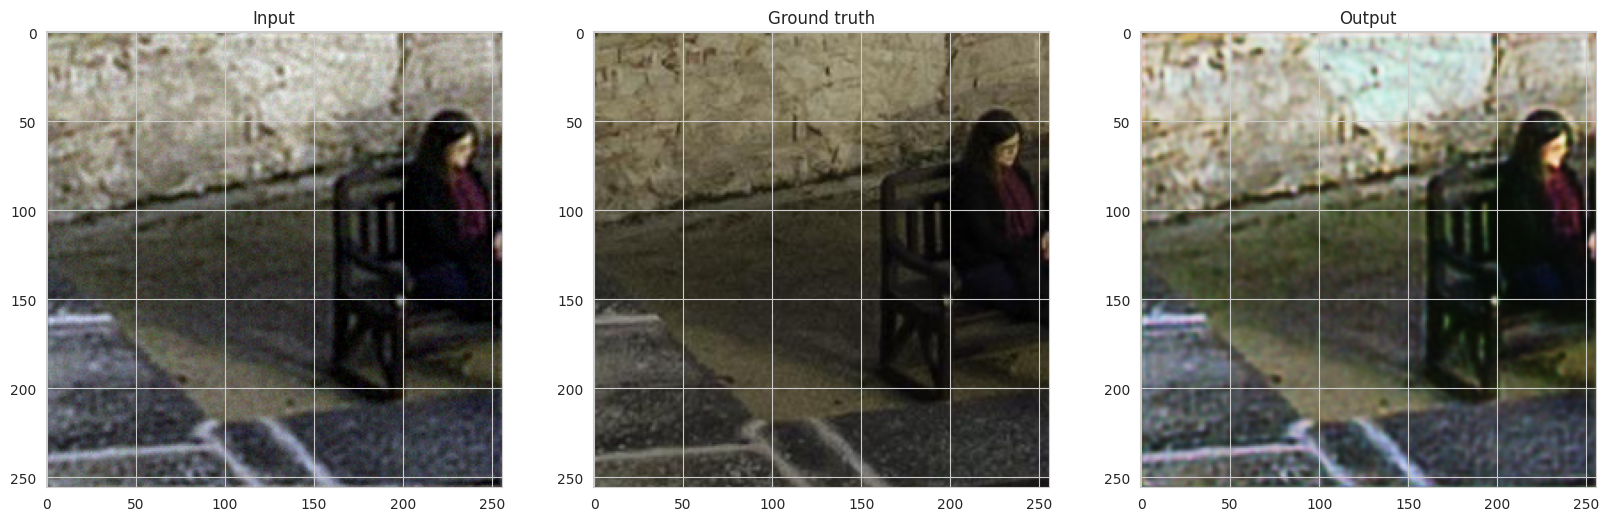

In [18]:
model, history = load_model_and_history('mse', 1, 64, 1024)
test_image_context(model, test_input[13], test_gt[13])

t-statistic: 67.38663262149419, p-value: 0.0


img       mse       psnr  \
0     /home/maciejka/Desktop/school/S8/labwork-proje...  0.045707  13.400174   
1     /home/maciejka/Desktop/school/S8/labwork-proje...  0.112476   9.489399   
2     /home/maciejka/Desktop/school/S8/labwork-proje...  0.069392  11.586928   
3     /home/maciejka/Desktop/school/S8/labwork-proje...  0.017981  17.451793   
4     /home/maciejka/Desktop/school/S8/labwork-proje...  0.037188  14.295949   
...                                                 ...       ...        ...   
1567  /home/maciejka/Desktop/school/S8/labwork-proje...  0.015413  18.121269   
1568  /home/maciejka/Desktop/school/S8/labwork-proje...  0.020394  16.904895   
1569  /home/maciejka/Desktop/school/S8/labwork-proje...  0.062069  12.071238   
1570  /home/maciejka/Desktop/school/S8/labwork-proje...  0.018827  17.252166   
1571  /home/maciejka/Desktop/school/S8/labwork-proje...  0.035794  14.461869   

          ssim       Loss type  
0     0.342544        MSE loss  
1     0.316120        MSE loss  
2     0.464351        MSE loss  
3     0.645776        MSE loss  
4     0.650744        MSE loss  
...        ...             ...  
1567  0.499818  Frequency loss  
1568  0.456410  Frequency loss  
1569  0.328038  Frequency loss  
1570  0.371206  Frequency loss  
1571  0.442860  Frequency loss  

[1572 rows x 5 columns]

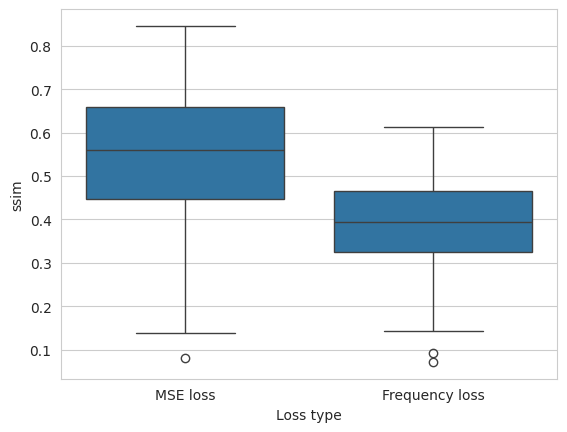

In [19]:
import seaborn as sns
from scipy import stats
# comparision - frequency vs mse
test_val = 'ssim'
data1 = ['mse', 1, 64, 1024]
data2 = ['focal', 1, 64, 1024]

test_data_1 = load_test_data(*data1)
test_data_2 = load_test_data(*data2)

test_data_1['Loss type'] = 'MSE loss'
test_data_2['Loss type'] = 'Frequency loss'

df = pd.concat([test_data_1, test_data_2], ignore_index=True)

sns.boxplot(x='Loss type', y=test_val, data=df)#, split=True, inner='quartile')

t_stat, p_value = stats.ttest_rel(test_data_1[test_val], test_data_2[test_val], alternative='two-sided')
print(f"t-statistic: {t_stat}, p-value: {p_value}")

df


In [20]:


test_val = 'ssim'
data_1_diff = 'MSE loss'
data_2_diff = 'frequency loss'
data1 = ['mse', 1, 64, 256]
data2 = ['frequency', 1, 64, 256]

df1 = load_test_data(*data1)
df2 = load_test_data(*data2)
suffix1 = '{} - {}'.format(test_val, data_1_diff)
suffix2 = '{} - {}'.format(test_val, data_2_diff)

df = df1.merge(df2,
               on="img",
               suffixes=(" - {}".format(data_1_diff)," - {}".format(data_2_diff)))

a = df['{} - {}'.format(test_val, data_1_diff)]
b = df['{} - {}'.format(test_val, data_2_diff)]

t_stat, p_t = stats.ttest_rel(a, b, alternative='two-sided')

print(f"t-statistic: {t_stat}, p-value: {p_t}")


df_long = pd.melt(df, id_vars=['img'], value_vars=[suffix1, suffix2], var_name='Loss type', value_name=test_val)
df_long['Loss type'] = df_long['Loss type'].replace({suffix1: data_1_diff, suffix2: data_2_diff})


#plt.hist(df1[test_val] - df2[test_val], bins=42, label=data_1_diff)

plt.figure(figsize=(8,6))
sns.boxplot(x='Loss type', y=test_val, data=df_long, width=0.5, fliersize=3)

# overlay paired lines
x_coords = {'MSE loss':0, 'Frequency loss':1}
for _, row in df.iterrows():
    delta = row[suffix1] - row[suffix2]
    color = 'red' if delta > 0 else 'green'
    #plt.plot([x_coords['MSE loss'], x_coords['Frequency loss']], [row[suffix1], row[suffix2]], color=color, alpha=0.1, linewidth=0.4)


green_line = mlines.Line2D([], [], color='green', label='Improved SSIM')
red_line = mlines.Line2D([], [], color='red', label='Declined SSIM')

plt.legend(handles=[green_line, red_line], loc='upper left')

plt.title('SSIM difference - {} vs. {}'.format(data_1_diff, data_2_diff))
plt.xlabel('Loss type')
plt.ylabel('SSIM')



plt.tight_layout()
plt.show()


TypeError: read_csv() missing 1 required positional argument: 'filepath_or_buffer'

In [21]:

def compare_models(data1_info, data2_info, test_val='ssim', data_1_diff='model 1', data_2_diff='model 2', plot_xlabel = 'Loss type', plot_lines=True):
    df1 = load_test_data(*data1_info)
    df2 = load_test_data(*data2_info)
    suffix1 = '{} - {}'.format(test_val, data_1_diff)
    suffix2 = '{} - {}'.format(test_val, data_2_diff)

    df = df1.merge(df2,
                   on="img",
                   suffixes=(" - {}".format(data_1_diff)," - {}".format(data_2_diff)))

    a = df['{} - {}'.format(test_val, data_1_diff)]
    b = df['{} - {}'.format(test_val, data_2_diff)]

    t_stat, p_t = stats.ttest_rel(a, b, alternative='two-sided')

    print(f"t-statistic: {t_stat}, p-value: {p_t}")

    df_long = pd.melt(df, id_vars=['img'], value_vars=[suffix1, suffix2], var_name='Loss type', value_name=test_val)
    df_long['Loss type'] = df_long['Loss type'].replace({suffix1: data_1_diff, suffix2: data_2_diff})

    plt.figure(figsize=(8,6))
    sns.boxplot(x='Loss type', y=test_val, data=df_long, width=0.5, fliersize=3)

    # overlay paired lines
    if plot_lines:
        x_coords = {'MSE loss':0, 'Frequency loss':1}
        for _, row in df.iterrows():
            delta = row[suffix1] - row[suffix2]

            if test_val == 'ssim':
                color = 'red' if delta > 0 else 'green'
                plt.plot([x_coords['MSE loss'], x_coords['Frequency loss']], [row[suffix1], row[suffix2]], color=color, alpha=0.1, linewidth=0.4)
            elif test_val == 'mse':
                color = 'green' if delta > 0 else 'red'
                plt.plot([x_coords['MSE loss'], x_coords['Frequency loss']], [row[suffix1], row[suffix2]], color=color, alpha=0.1, linewidth=0.4)

        if test_val == 'ssim':
            green_line = mlines.Line2D([], [], color='green', label='Improved SSIM')
            red_line = mlines.Line2D([], [], color='red', label='Declined SSIM')
        elif test_val == 'mse':
            green_line = mlines.Line2D([], [], color='green', label='Improved MSE')
            red_line = mlines.Line2D([], [], color='red', label='Worsened MSE')

        plt.legend(handles=[green_line, red_line], loc='upper left')


    if test_val == 'ssim':
        plot_title = 'SSIM difference - {} vs. {}'.format(data_1_diff, data_2_diff)
        plot_ylabel = 'SSIM'
    elif test_val == 'mse':
        plot_title = 'MSE difference - {} vs. {}'.format(data_1_diff, data_2_diff)
        plot_ylabel = 'MSE'
    else:
        raise ValueError("Invalid test value. Choose 'ssim' or 'mse'.")

    plt.title(plot_title)
    plt.xlabel(plot_xlabel)
    plt.ylabel(plot_ylabel)

    plt.tight_layout()
    plt.show()


t-statistic: -28.88212298288704, p-value: 1.535258530649966e-125


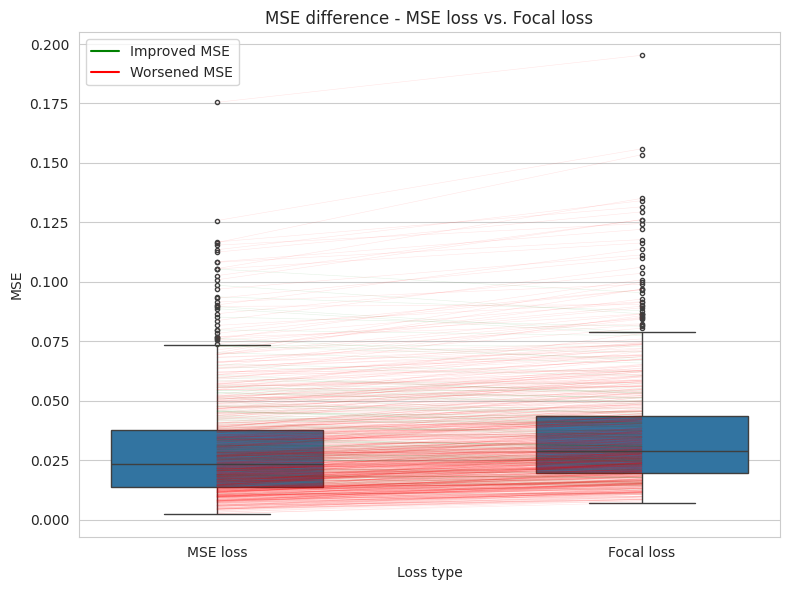

t-statistic: -28.88212298288704, p-value: 1.535258530649966e-125


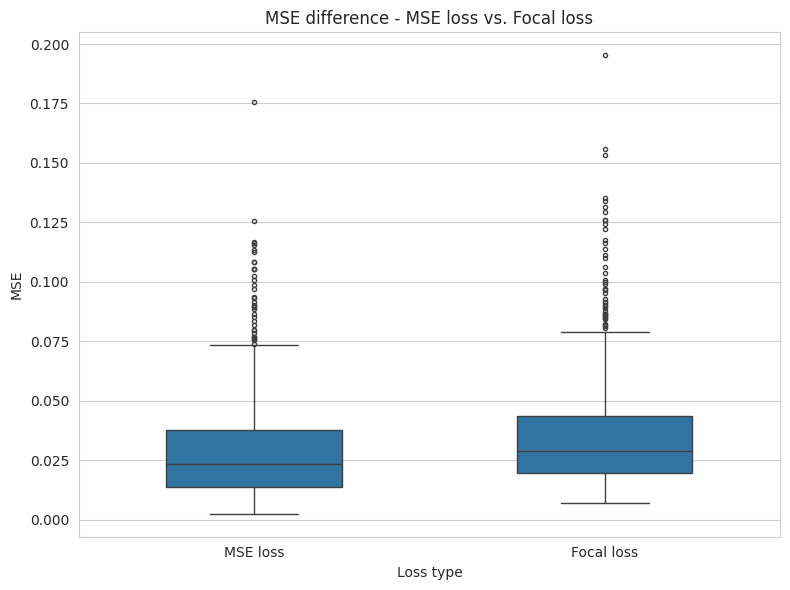

t-statistic: 67.38663262149419, p-value: 0.0


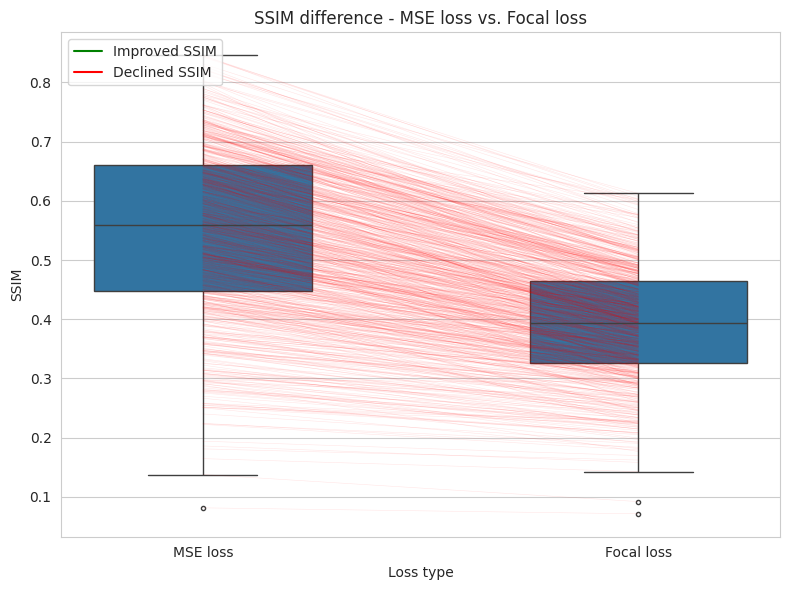

t-statistic: 67.38663262149419, p-value: 0.0


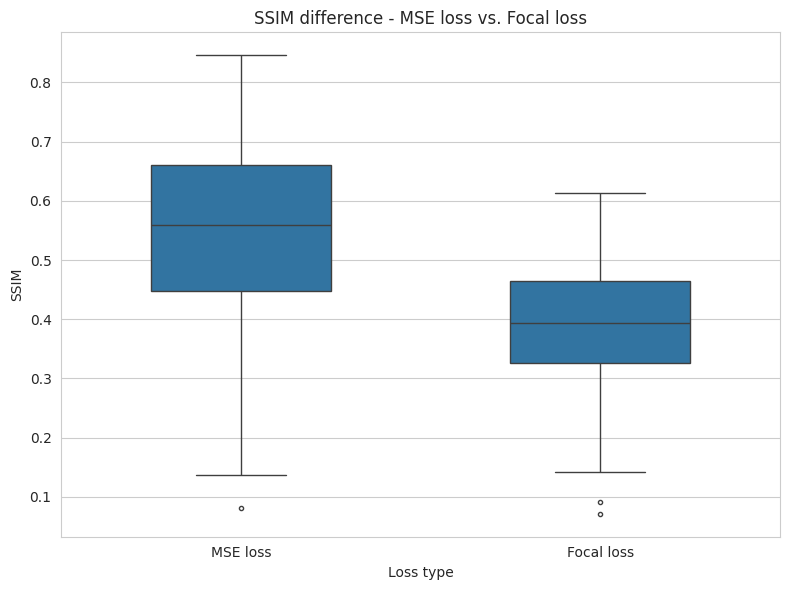

In [42]:
test_val = 'mse'
data_1_diff = 'MSE loss'
data_2_diff = 'Focal loss'
plot_xlabel = 'Loss type'
plot_lines = False
#plot_xlabel = 'Loss type'
data1 = ['mse', 1, 64, 1024]
data2 = ['focal', 1, 64, 1024]

compare_models(data1, data2, 'mse', data_1_diff, data_2_diff, plot_xlabel=plot_xlabel, plot_lines=True)
compare_models(data1, data2, 'mse', data_1_diff, data_2_diff, plot_xlabel=plot_xlabel, plot_lines=False)
compare_models(data1, data2, 'ssim', data_1_diff, data_2_diff, plot_xlabel=plot_xlabel, plot_lines=True)
compare_models(data1, data2, 'ssim', data_1_diff, data_2_diff, plot_xlabel=plot_xlabel, plot_lines=False)

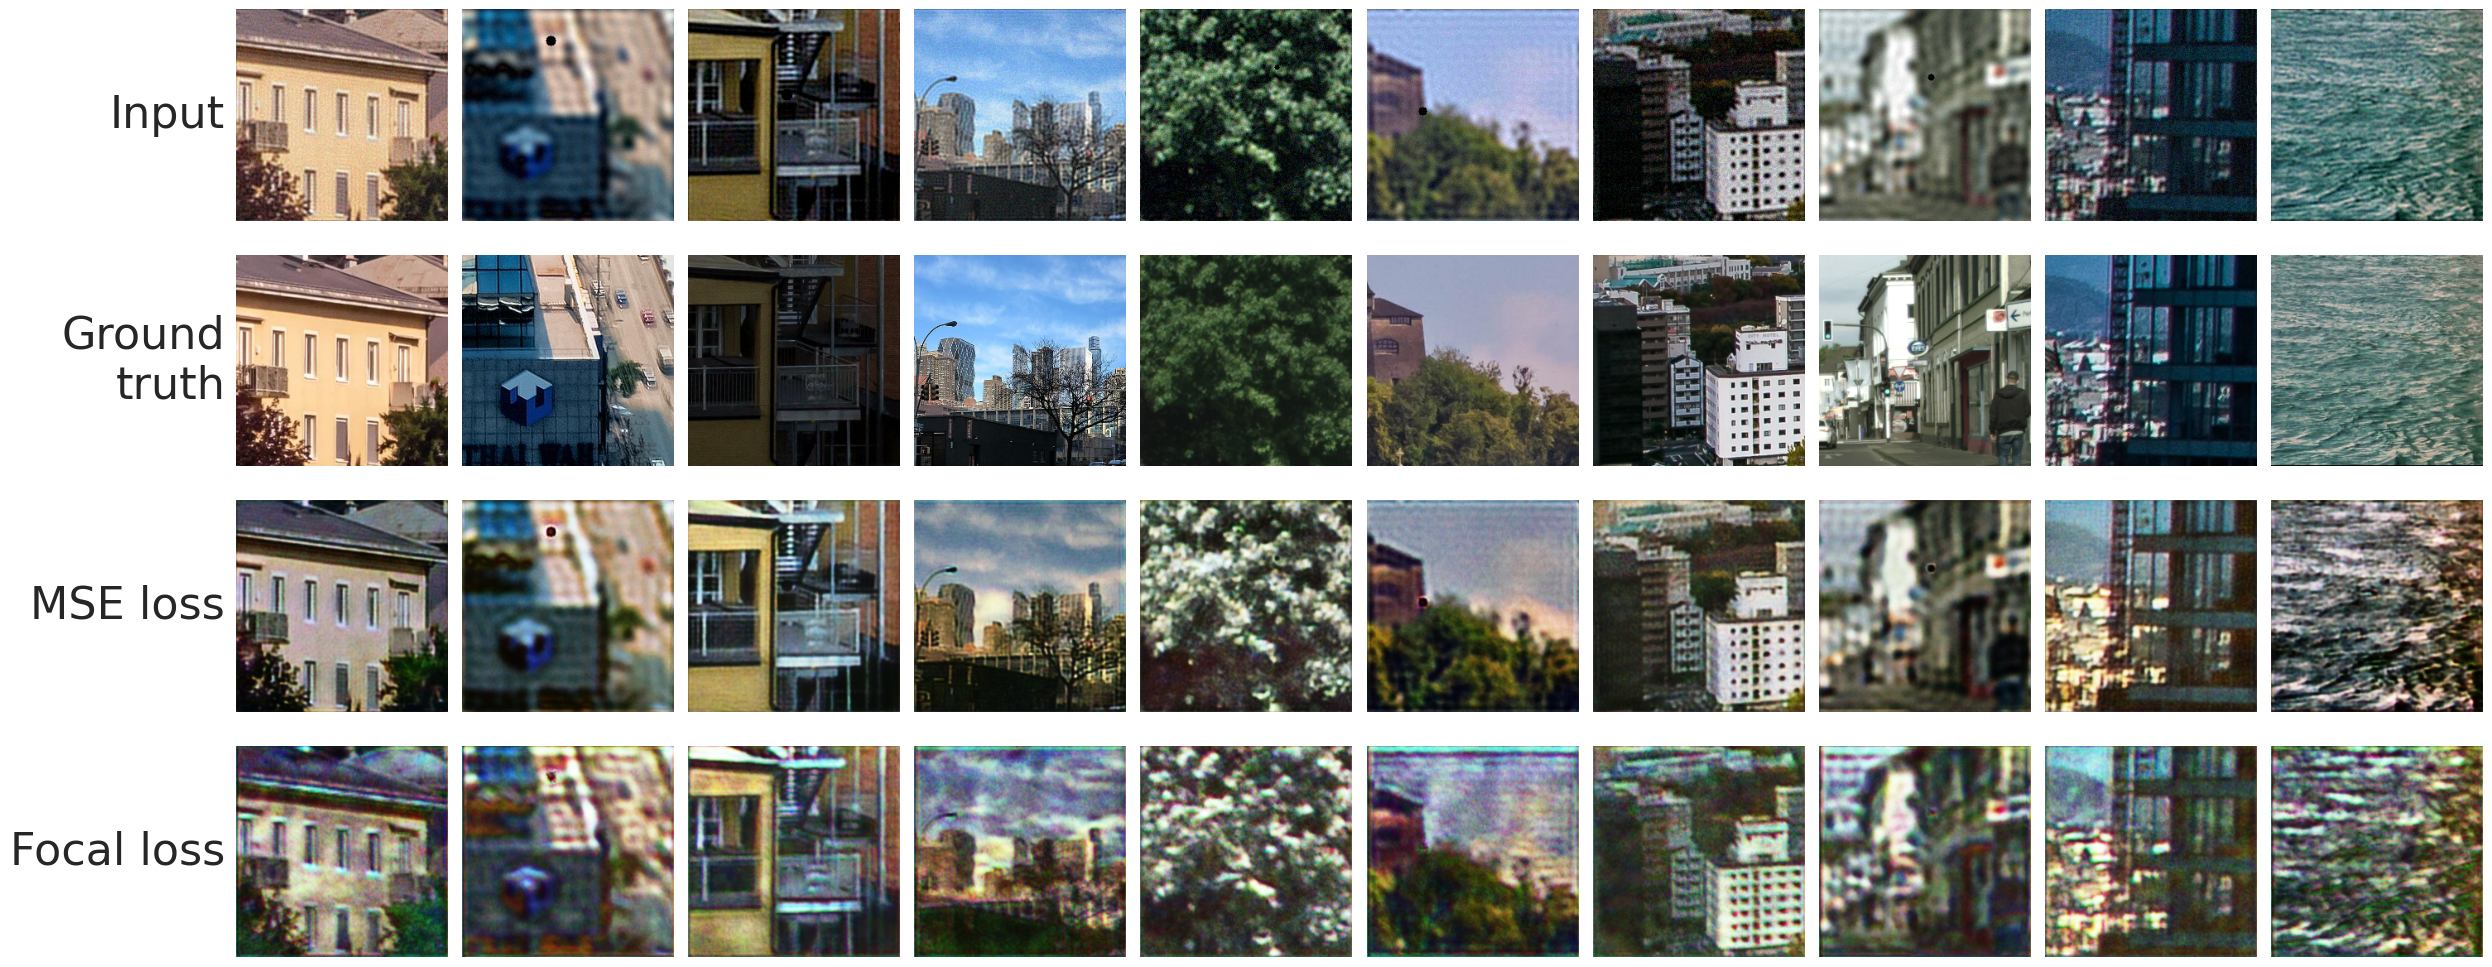

In [44]:
def show_image(ax, img, title = ''):
    ax.imshow(img)
    ax.set_title(title)
    ax.grid(False)
    ax.axis('off')

model1, _ = load_model_and_history(*data1)
model2, _ = load_model_and_history(*data2)
inx = 'best'
m1_name = 'MSE loss'
m2_name = 'Focal loss'

if inx == 'best':
    df1 = load_test_data(*data1)

    best_row = df1.loc[df1['mse'].idxmin()]
    inx = best_row.name

num_images = 10
fig, ax = plt.subplots(4, num_images, figsize=(2.5*num_images, 10))
for n in range(num_images):
    inx = np.random.randint(len(test_input))
    classify_image(model1, test_input[inx], test_gt[inx], output='image')

    inp = cv2.imread(test_input[inx], cv2.IMREAD_COLOR).astype(np.float32) / 255.0
    inp = cv2.cvtColor(inp, cv2.COLOR_BGR2RGB)

    gt = cv2.imread(test_gt[inx], cv2.IMREAD_COLOR).astype(np.float32) / 255.0
    gt = cv2.cvtColor(gt, cv2.COLOR_BGR2RGB)

    m1_output = classify_image(model1, test_input[inx], test_gt[inx], output='image')
    m2_output = classify_image(model2, test_input[inx], test_gt[inx], output='image')

    show_image(ax[0, n], inp)
    show_image(ax[1, n], gt)
    show_image(ax[2, n], m1_output)
    show_image(ax[3, n], m2_output)


ax[0, 0].text(-0.05, 0.5, 'Input', va='center', ha='right', rotation=0, fontsize=32, transform=ax[0, 0].transAxes)
ax[1, 0].text(-0.05, 0.5, 'Ground\ntruth', va='center', ha='right', rotation=0, fontsize=32, transform=ax[1, 0].transAxes)
ax[2, 0].text(-0.05, 0.5, m1_name, va='center', ha='right', rotation=0, fontsize=32, transform=ax[2, 0].transAxes)
ax[3, 0].text(-0.05, 0.5, m2_name, va='center', ha='right', rotation=0, fontsize=32, transform=ax[3, 0].transAxes)

fig.tight_layout()
#fig.show()



Text(0, 0.5, 'validation loss [-]')

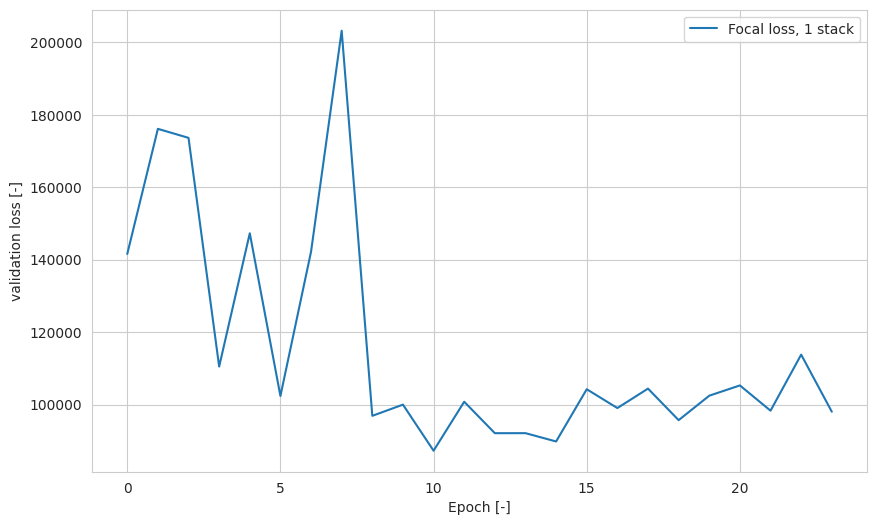

In [47]:
datas = [
    ['focal', 1, 64, 1024]
    ]
names = [
    'Focal loss, 1 stack',
]
epochs = 100
df_out = pd.DataFrame()
dfs = []
for data in datas:
    _, df = load_model_and_history(*data)
    #df['val_loss'] = df['val_loss'] / df['val_loss'].max()
    dfs.append(df)

df_merged = pd.concat([d['val_loss'].rename(f'{names[i]}') for i, d in enumerate(dfs)], axis=1)

df_merged.plot(figsize=(10, 6))
plt.xlabel('Epoch [-]')
plt.ylabel('validation loss [-]')

In [50]:


image = cv2.imread(test_input[inx], cv2.IMREAD_COLOR).astype(np.float32) / 255.0
image_numpy = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

x = transform(image_numpy).unsqueeze(0)
torch.onnx.export(model1,x, 'model.onnx', input_names=['input'], output_names=['output'], opset_version=12)

OnnxExporterError: Module onnx is not installed!